In [1]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import random
import networkx as nx
import matplotlib.patches as mpatches

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

import gymnasium as gym
from gymnasium import Env, spaces

from sklearn import preprocessing


c:\Users\tass\anaconda3\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



Configurar o Enxame


In [2]:

num_drones = 3
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[18, 52], [33, 20], [44, 15]])
posicao_jammer = np.array([38, 50])

VIZUALIZAÇÃO DAS DIREÇÕES DAS ANTENAS ESCOLHIDAS ALEATORIAMENTE

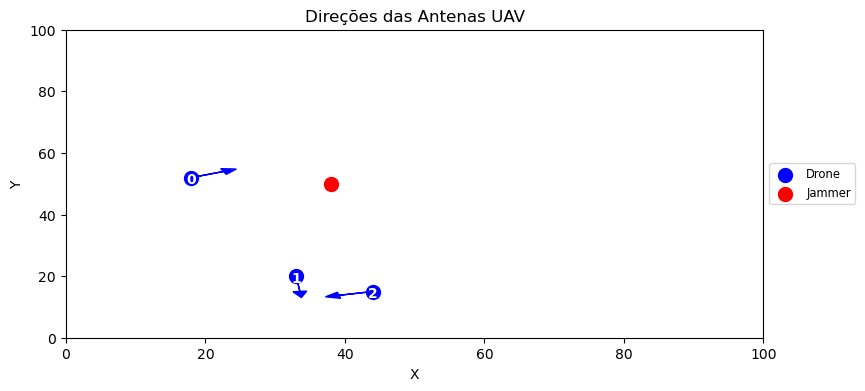

In [3]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5



# Visualização usando Matplotlib
def render_v2(posicoes, direcoes_antena, posicao_jammer, comprimento_seta=5, area_size=(100, 100)):
    afetados_pelo_jammer = verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)

    fig, ax = plt.subplots(figsize=(9, 4))

    # Desenha os drones no gráfico
    for i, pos in enumerate(posicoes):
        ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
        ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

    # Desenha as setas para a direção das antenas
    for i, direcao in enumerate(direcoes_antena):
        direcao_rad = np.radians(direcao)  # Converte para radianos
        dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
        dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
        
        ax.arrow(
            posicoes[i][0], posicoes[i][1], 
            dx, dy, 
            head_width=2, head_length=2, fc='b', ec='b'
        )  # Seta azul para indicar a direção da antena

    # Desenha o jammer
    ax.scatter(posicao_jammer[0], posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

    # Configurações finais do gráfico
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, area_size[0])
    ax.set_ylim(0, area_size[1])
    ax.set_yticks(np.arange(0, area_size[1]+1, 20))
    plt.title('Direções das Antenas UAV')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    plt.show()

render_v2(posicoes, direcoes_antena, posicao_jammer, comprimento_seta)


CALCULO DE TODOS OS ANGULOS A USAR

In [4]:
import numpy as np

# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
# direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' com um ângulo:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' com um ângulo:
  Com o drone 1: 272 graus
  Com o drone 2: 282 graus
Drones que o drone 1 'vê' com um ângulo:
  Com o drone 0: 199 graus
  Com o drone 2: 59 graus
Drones que o drone 2 'vê' com um ângulo:
  Com o drone 0: 291 graus
  Com o drone 1: 321 graus


PARAMETROS 


In [5]:
Ptx_dBm = 20 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 0
c=3e8
lambda_m=c/f
L0=30
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')

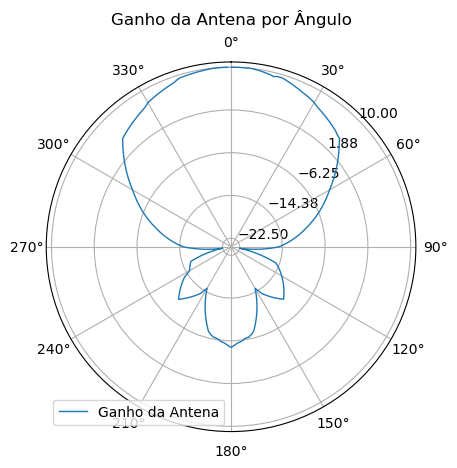

In [6]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [7]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    
    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    # print('Angulo receção:',angulo_rececao)
    # print('Angulo tranmissão:',angulo_transmissao)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos( angulo_transmissao)
    ganho_rececao = busca_ganhos( angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

# ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    # L = (4 * np.pi * d / lambda_m)**2
    # Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    # return Prx_dBm
    # Calcular a perda de percurso
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0  # Se a distância for zero, assume-se a perda na distância de referência

    # Calcular a potência do sinal recebido
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L

    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")



Ganhos Rx,Tx: -14.2 -9.5
  Potencia recebida do drone 0 para o drone 1: -64.67 dBm
  Ruido recebido no drone 1 e do jammer: 22.29 dBm
  Capacidade do canal 0 para 1: 0.01 bps
Ganhos Rx,Tx: -10.2 -6.36
  Potencia recebida do drone 0 para o drone 2: -59.67 dBm
  Ruido recebido no drone 2 e do jammer: 10.95 dBm
  Capacidade do canal 0 para 2: 0.30 bps
Ganhos Rx,Tx: -9.5 -14.2
  Potencia recebida do drone 1 para o drone 0: -64.67 dBm
  Ruido recebido no drone 0 e do jammer: 41.52 dBm
  Capacidade do canal 1 para 0: 0.00 bps
Ganhos Rx,Tx: -2.0 5.9
  Potencia recebida do drone 1 para o drone 2: -27.74 dBm
  Ruido recebido no drone 2 e do jammer: 10.95 dBm
  Capacidade do canal 1 para 2: 468.08 bps
Ganhos Rx,Tx: -6.36 -10.2
  Potencia recebida do drone 2 para o drone 0: -59.67 dBm
  Ruido recebido no drone 0 e do jammer: 41.52 dBm
  Capacidade do canal 2 para 0: 0.00 bps
Ganhos Rx,Tx: 5.9 -2.0
  Potencia recebida do drone 2 para o drone 1: -27.74 dBm
  Ruido recebido no drone 1 e do jammer: 2

COM O DJIKSTRA DENTRO DO AMBIENTE

In [8]:
seed = 0

class UAVCommunicationEnvDjikstra(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes.copy()
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}

        # Define o espaço de ação: direções das antenas + deslocamentos x e y
        self.action_space = spaces.Box(low=np.array([0]*num_uavs + [-10]*num_uavs + [-10]*num_uavs), 
                                       high=np.array([360]*num_uavs + [10]*num_uavs + [10]*num_uavs), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=360, shape=(num_uavs,), dtype=np.float32)

        self.direcoes_antena = np.random.uniform(0, 360, size=num_uavs)
        self.capacidades = []  # Inicializa a lista de capacidades para normalização

    def step(self, action):
        # Separar ações em direções das antenas e movimentos
        direcoes_antena = action[:self.num_uavs]
        movimentos_x = action[self.num_uavs:2*self.num_uavs]
        movimentos_y = action[2*self.num_uavs:]

        # Atualizar direções das antenas
        self.direcoes_antena = np.array(direcoes_antena)
        
        # Atualizar posições dos drones com os movimentos
        for i in range(self.num_uavs):
            nova_pos_x = self.posicoes[i][0] + movimentos_x[i]
            nova_pos_y = self.posicoes[i][1] + movimentos_y[i]
            # Garantir que os drones fiquem dentro dos limites da área
            nova_pos_x = min(max(nova_pos_x, 0), self.area_size[0])
            nova_pos_y = min(max(nova_pos_y, 0), self.area_size[1])
            self.posicoes[i] = np.array([nova_pos_x, nova_pos_y])

        capacidades_por_link = []

        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    d = distancia(self.posicoes[i], self.posicoes[j])
                    ganho_transmissao, ganho_rececao = calcula_ganhos(self.posicoes, self.direcoes_antena, i, j, ganhos_df)
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(self.posicoes[j], self.direcoes_antena[j], self.posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal = calcula_capacidade(potencia_recebida, potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)

        capacidade_media = np.mean(capacidades_por_link)
        capacidade_minima = np.min(capacidades_por_link)

        self.capacidades.extend(capacidades_por_link)
        if len(self.capacidades) > 1000:  # Manter apenas as últimas 1000 capacidades
            self.capacidades = self.capacidades[-1000:]

        min_capacidade = np.min(self.capacidades)
        max_capacidade = np.max(self.capacidades)
        capacidade_media_normalizada = (capacidade_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        capacidade_minima_normalizada = (capacidade_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        G = nx.Graph()
        num_drones = self.posicoes.shape[0]
        capacidade_matriz = np.zeros((self.num_uavs, self.num_uavs))
        link_index = 0

        for i in range(self.num_uavs):
            for j in range(self.num_uavs):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        for i in range(num_drones):
            for j in range(i + 1, num_drones):
                capacidade = capacidade_matriz[i, j]
                G.add_edge(i, j, weight=1.0 / capacidade)

        bottlenecks = {}
        for i in range(num_drones):
            for j in range(num_drones):
                if i != j:
                    try:
                        caminho = nx.dijkstra_path(G, source=i, target=j, weight='weight')
                        menor_capacidade = float('inf')
                        for k in range(len(caminho) - 1):
                            cap_atual = capacidade_matriz[caminho[k], caminho[k+1]]
                            if cap_atual < menor_capacidade:
                                menor_capacidade = cap_atual
                        bottlenecks[(i, j)] = (caminho, menor_capacidade)
                    except nx.NetworkXNoPath:
                        print(f"Não há caminho do nó {i} para o nó {j}")

        capacidade_bottleneck_media = np.mean([bottleneck for caminho, bottleneck in bottlenecks.values()])
        capacidade_bottleneck_minima = np.min([bottleneck for caminho, bottleneck in bottlenecks.values()])

        capacidade_bottleneck_media_normalizada = (capacidade_bottleneck_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        capacidade_bottleneck_minima_normalizada = (capacidade_bottleneck_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        # Penalidade pela distância dos drones ao jammer
        distancia_jammer = np.mean([distancia(pos, self.posicao_jammer) for pos in self.posicoes])
        penalidade_distancia_jammer = (distancia_jammer / max(self.area_size)) ** 2

        # Penalidade pela proximidade dos drones uns aos outros
        distancias_entre_drones = [distancia(self.posicoes[i], self.posicoes[j]) for i in range(num_drones) for j in range(i+1, num_drones)]
        distancia_minima_entre_drones = np.min(distancias_entre_drones)
        penalidade_proximidade_drones = max(0, (15 - distancia_minima_entre_drones) / 15) ** 2  # Aumentar a penalidade e a distância mínima

        # Combinação de recompensas e penalidades com pesos ajustados
        recompensa = (0.5 * capacidade_media_normalizada + 0.5 * capacidade_bottleneck_minima_normalizada) - (0.9 * penalidade_distancia_jammer + 0.5 * penalidade_proximidade_drones)

        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)

        info = {
            'Recompensa': recompensa,
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz,
            'Capacidade mínima [Kbps]': capacidade_minima,
            'Capacidade média normalizada': capacidade_media_normalizada,
            'Capacidade mínima normalizada': capacidade_minima_normalizada,
            'Capacidade bottleneck média': capacidade_bottleneck_media,
            'Capacidade bottleneck mínima': capacidade_bottleneck_minima,
            'Capacidade bottleneck média normalizada': capacidade_bottleneck_media_normalizada,
            'Capacidade bottleneck mínima normalizada': capacidade_bottleneck_minima_normalizada,
            'Penalidade distância ao jammer': penalidade_distancia_jammer,
            'Penalidade proximidade entre drones': penalidade_proximidade_drones
        }

        done = False
        return np.array(self.direcoes_antena), recompensa, done, info


    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        comprimento_seta = 5
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)
            dx = comprimento_seta * np.cos(direcao_rad)
            dy = comprimento_seta * np.sin(direcao_rad)
            
            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1], 
                dx, dy, 
                head_width=2, head_length=2, fc='b', ec='b'
            )

        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        ax.set_yticks(np.arange(0, self.area_size[1]+1, 20))  # Configurar a escala vertical de 20 em 20
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()
        
    def reset(self):
        super().reset(seed=seed)
        self.direcoes_antena = np.random.uniform(0, 360, size=self.num_uavs)
        self.posicoes = posicoes.copy()
        obs = np.array(self.direcoes_antena)
        return obs, {}


ALGORITMO GENETICO

1.Tamanho da População:

    Maior: Uma população maior oferece uma diversidade genética mais ampla, o que pode ajudar a evitar mínimos locais, mas também aumenta o custo computacional.
    Menor: Uma população menor pode levar a uma convergência mais rápida, mas pode ficar presa em mínimos locais.

2.Taxa de Mutação:

    Alta: Uma taxa de mutação mais alta aumenta a diversidade genética dentro da população e pode ajudar a sair de mínimos locais. No entanto, se for muito alta, pode causar uma busca aleatória, reduzindo a eficiência do algoritmo.
    Baixa: Uma taxa de mutação baixa mantém a estabilidade da população, mas pode resultar em convergência prematura para soluções subótimas.

3.Taxa de Cruzamento:

    Alta: Promove a combinação de características de diferentes indivíduos, potencialmente levando a uma melhoria mais rápida.
    Baixa: Reduz a probabilidade de alterar boas soluções, mas pode limitar a capacidade do algoritmo de explorar novas e potencialmente melhores áreas do espaço de busca.

4.Número de Gerações:

    Maior número de gerações: Permite mais iterações do processo de seleção, cruzamento e mutação, dando mais tempo para a população evoluir.
    Menor número de gerações: Pode ser suficiente se a convergência for rápida, mas corre o risco de não permitir desenvolvimento suficiente, especialmente com uma taxa de mutação baixa.

In [9]:
class GeneticAlgorithm:
    def __init__(self, env, population_size=1000, generations=50, mutation_rate=0.15, crossover_rate=0.9):
        self.env = env
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        self.population = [self.random_chromosome() for _ in range(population_size)]
        assert len(self.population) == self.population_size, "Tamanho da população incorreto"
        for chrom in self.population:
            assert len(chrom) == 3 * self.env.num_uavs, "Número de genes no cromossomo está errado"

    def random_chromosome(self):
        return np.concatenate([
            np.random.uniform(0, 360, size=self.env.num_uavs),
            np.random.uniform(-10, 10, size=self.env.num_uavs),
            np.random.uniform(-10, 10, size=self.env.num_uavs)
        ])

    def evaluate_fitness(self, chromosome):
        obs, _ = self.env.reset()
        action = np.array(chromosome)
        try:
            obs, reward, done, info = self.env.step(action)
            return (reward, info)
        except Exception as e:
            print(f"Erro: {e}")
            return (0, {})

    def select(self):
        tournament_size = 5
        selected = []
        fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
        for _ in range(self.population_size):
            contenders = random.sample(list(enumerate(fitness_scores)), tournament_size)
            winner_index = max(contenders, key=lambda item: item[1][0])[0]
            selected.append(self.population[winner_index])
        return selected

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, 3 * self.env.num_uavs - 1)
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
            return child1, child2
        else:
            return parent1, parent2

    def mutate(self, chromosome):
        for i in range(len(chromosome)):
            if random.random() < self.mutation_rate:
                if i < self.env.num_uavs:  # Mutações nos ângulos das antenas
                    mutation = random.uniform(-30, 30)
                    chromosome[i] = (chromosome[i] + mutation) % 360
                else:  # Mutações nos movimentos dos drones
                    mutation = random.uniform(-5, 5)
                    chromosome[i] += mutation
                
        # print(chromosome)
        return chromosome

    def run(self):
        best_info = None
        for generation in range(self.generations):
            new_population = []
            parents = self.select()
            
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(parents, 2)
                child1, child2 = self.crossover(parent1, parent2)
                new_population.extend([self.mutate(child1), self.mutate(child2)])
            
            self.population = new_population[:self.population_size]
            fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
            best_fitness, best_info = max(fitness_scores, key=lambda x: x[0])
            
            print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")
        
        best_solution_index = max(range(len(self.population)), key=lambda i: fitness_scores[i][0])
        best_solution = self.population[best_solution_index]
        print(best_solution)
        return best_solution, best_info

In [10]:
# Criação do ambiente
env = UAVCommunicationEnvDjikstra()


# Criação do algoritmo genético
ga = GeneticAlgorithm(env)

# Executar o algoritmo genético
best_solution, best_info = ga.run()

# Renderizar a melhor solução
env.direcoes_antena = best_solution[:env.num_uavs]
for i in range(env.num_uavs):
    env.posicoes[i][0] += best_solution[env.num_uavs + i]
    env.posicoes[i][1] += best_solution[2 * env.num_uavs + i]
env.render()

print("Direções das Antenas:", best_solution[:env.num_uavs])
print("Movimentos X:", best_solution[env.num_uavs:2*env.num_uavs])
print("Movimentos Y:", best_solution[2*env.num_uavs:3*env.num_uavs])

if 'Recompensa' in best_info:
    print("\nRecompensa:", best_info['Recompensa'])
if 'Capacidade média [Kbps]' in best_info:
    print("\nCapacidade Média [Kbps]:", best_info['Capacidade média [Kbps]'])
if 'Capacidade bottleneck média' in best_info:
    print("\nCapacidade bottleneck média:", best_info['Capacidade bottleneck média'])
if 'Capacidades_por_link [Kbps]' in best_info:
    print("\nCapacidade por Link [Kbps]:", best_info['Capacidades_por_link [Kbps]'])
if 'Matriz de Capacidades [Kbps]' in best_info:
    print("\nMatriz de Capacidades [Kbps]:", '\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in best_info['Matriz de Capacidades [Kbps]']]))
    capacidade_matriz = best_info['Matriz de Capacidades [Kbps]']






Generation 0: Best Fitness = 0.03
Generation 1: Best Fitness = 0.03
Generation 2: Best Fitness = 0.05
Generation 3: Best Fitness = 0.07
Generation 4: Best Fitness = 0.06
Generation 5: Best Fitness = 0.06
Generation 6: Best Fitness = 0.02


KeyboardInterrupt: 

ALGORITMO DIJKSTRA

https://www.w3schools.com/dsa/dsa_algo_graphs_dijkstra.php

In [ ]:
# Criar um grafo
G = nx.Graph()

# Adicionar arestas ao grafo com o inverso das capacidades como pesos
num_drones = posicoes.shape[0]
for i in range(num_drones):
    for j in range(i + 1, num_drones):
        capacidade = capacidade_matriz[i, j]
        G.add_edge(i, j, weight=1.0 / capacidade)  # Usando o inverso das capacidades como peso

# Calcular o caminho mais curto usando Dijkstra para cada par de nós
bottlenecks = {}
for i in range(num_drones):
    for j in range(num_drones):
        if i != j:
            try:
                caminho = nx.dijkstra_path(G, source=i, target=j, weight='weight')
                # Encontrar o bottleneck no caminho
                menor_capacidade = float('inf')
                for k in range(len(caminho) - 1):
                    cap_atual = capacidade_matriz[caminho[k], caminho[k+1]]
                    if cap_atual < menor_capacidade:
                        menor_capacidade = cap_atual
                bottlenecks[(i, j)] = (caminho, menor_capacidade)
            except nx.NetworkXNoPath:
                print(f"Não há caminho do nó {i} para o nó {j}")

# Imprimir os caminhos e o bottleneck de cada um
for key, (caminho, bottleneck) in bottlenecks.items():
    print(f"Caminho do nó {key[0]} para o nó {key[1]}: {caminho}, Bottleneck: {bottleneck:.3f}")
    
capacidade_bottleneck_media = np.mean([bottleneck for caminho, bottleneck in bottlenecks.values()])
print('Capacidade de Bottleneck Media:',capacidade_bottleneck_media)


Caminho do nó 0 para o nó 1: [0, 2, 1], Bottleneck: 7.752
Caminho do nó 0 para o nó 2: [0, 2], Bottleneck: 7.752
Caminho do nó 1 para o nó 0: [1, 2, 0], Bottleneck: 0.004
Caminho do nó 1 para o nó 2: [1, 2], Bottleneck: 23186.046
Caminho do nó 2 para o nó 0: [2, 0], Bottleneck: 0.004
Caminho do nó 2 para o nó 1: [2, 1], Bottleneck: 25773.480
Capacidade de Bottleneck Media: 8162.506310379166
